In [18]:
!pip install ultralytics

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


In [19]:
import torch
import torch.version
print(torch.__version__)

2.7.1


In [20]:
import os
import time
import json
import requests
from zipfile import ZipFile
import tarfile
from shutil import copyfile
import shutil
from dataclasses import dataclass, field

import yaml
import glob

import random
import numpy as np
import pandas as pd 
import cv2

from ultralytics import YOLO

import matplotlib.pyplot as plt


In [21]:
!ls

Cats            cat_keypoints   yolov8m-pose.pt
Cats.zip        cat_pose.ipynb  yolov8s-pose.pt


In [22]:
ANNOTATION_PATH = './Cats/annotations/'
VAL_JSON_PATH = os.path.join(ANNOTATION_PATH, 'val' + '.json')
TRAIN_JSON_PATH = os.path.join(ANNOTATION_PATH, 'train' + '.json')

with open(VAL_JSON_PATH, 'r') as f:
    val_json = json.load(f)

VAL_IMAGE_SIZE = len(val_json['images'])
VAL_ANNOTATION_SIZE = len(val_json['annotations'])

with open(TRAIN_JSON_PATH, 'r') as f:
    train_json = json.load(f)

TRAIN_IMAGE_SIZE = len(train_json['images'])
TRAIN_ANNOTATION_SIZE = len(train_json['annotations'])

val_anno_dict = {}
val_box_dict = {}
val_image_size = {}

train_anno_dict = {}
train_box_dict = {}
train_image_size = {}

for i in range(VAL_IMAGE_SIZE):
    image_id = val_json['images'][i]['id']
    val_image_size[image_id] = (val_json['images'][i]['height'], val_json['images'][i]['width'])

for i in range(TRAIN_IMAGE_SIZE):
    image_id = train_json['images'][i]['id']
    train_image_size[image_id] = (train_json['images'][i]['height'], train_json['images'][i]['width'])

for i in range(TRAIN_ANNOTATION_SIZE):
    image_id = train_json['annotations'][i]['image_id']
    if(image_id not in train_anno_dict.keys()):
        train_anno_dict[image_id] = []
        train_box_dict[image_id] = []
    train_anno_dict[image_id].append(train_json['annotations'][i]['keypoints'])
    train_box_dict[image_id].append(train_json['annotations'][i]['bbox'])

for i in range(VAL_ANNOTATION_SIZE):
    image_id = val_json['annotations'][i]['image_id']
    if(image_id not in val_anno_dict.keys()):
        val_anno_dict[image_id] = []
        val_box_dict[image_id] = []
    val_anno_dict[image_id].append(val_json['annotations'][i]['keypoints'])
    val_box_dict[image_id].append(val_json['annotations'][i]['bbox'])

# print(VAL_ANNOTATION_SIZE)
# print(len(list(set(val_anno_list) - set(val_list))))
# print(val_anno_dict[19])

In [23]:
def draw_keypoints(image_id):
    kps = val_anno_dict[image_id]
    print(len(kps))
    point_x = []
    point_y = []
    assert isinstance(kps, list)
    for i in range(17):
        if(kps[1][i*3+2] == 1):
            point_x.append(kps[1][i*3])
            point_y.append(kps[1][i*3+1])
    plt.scatter(point_x, point_y)

In [24]:
def draw_bounding_boxes(image_id):
    bbox = val_box_dict[image_id]
    print(bbox)
    plt.scatter([bbox[1][0], bbox[1][0] + bbox[1][2]], [bbox[1][1], bbox[1][3]])

2
[[31, 23, 449, 352], [330, 1, 170, 175]]


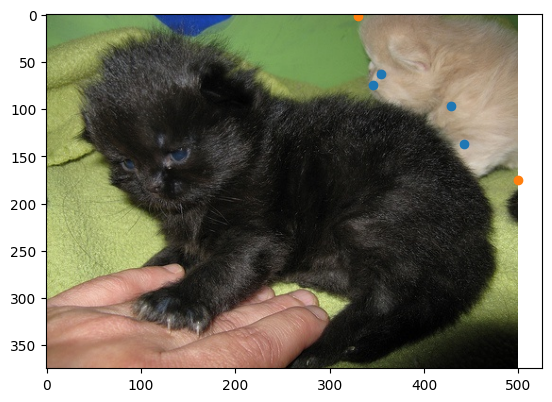

In [25]:
IMAGE_BASE_PATH = './Cats/images/'
image_path = os.path.join(IMAGE_BASE_PATH, '00000514.jpg')
# print(os.path.exists(image_path))
img0 = cv2.imread(image_path)
plt.figure()
plt.imshow(img0[:,:,::-1])
draw_keypoints(514)
draw_bounding_boxes(514)
plt.show()

In [26]:
def number2file(number):
    if isinstance(number, int):
        number = str(number)
    return number.zfill(8)

Using map to process through a iterable object, and use join to separate the iterable object with the whitespace.

In [27]:
l = [1, 2, 3, 0, 2]
print(" ".join(map(str, l)))

1 2 3 0 2


In [28]:
# !ls ./Cats/train/

In [29]:
TRAIN_LABELS_BASE_PATH = './Cats/train/labels'
TRAIN_IMAGES_BASE_PATH = './Cats/train/images'

VAL_LABELS_BASE_PATH = './Cats/valid/labels'
VAL_IMAGES_BASE_PATH = './Cats/valid/images'
IMAGES_BASE_PATH = './Cats/images'

os.makedirs(TRAIN_LABELS_BASE_PATH, exist_ok=True)
os.makedirs(TRAIN_IMAGES_BASE_PATH, exist_ok=True)
os.makedirs(VAL_LABELS_BASE_PATH, exist_ok=True)
os.makedirs(VAL_IMAGES_BASE_PATH, exist_ok=True)

# !ls ./Cats/
for k in range(len(val_anno_dict.values())):
    image_id = list(val_anno_dict.keys())[k]
    for i in range(len(val_box_dict[image_id])):
        image_name_jpg = os.path.join(VAL_IMAGES_BASE_PATH, number2file(image_id)) + '_' + str(i) + '.jpg'
        shutil.copy(os.path.join(IMAGES_BASE_PATH, number2file(image_id)) + '.jpg', image_name_jpg)
        image_name_txt = os.path.join(VAL_LABELS_BASE_PATH, number2file(image_id) + '_' + str(i) + '.txt')
        with open(image_name_txt, 'w') as f:
            img_h, img_w = val_image_size[image_id]
            xc = np.round((val_box_dict[image_id][i][0] + val_box_dict[image_id][i][2] / 2.0)/img_w, 4)
            yc = np.round((val_box_dict[image_id][i][1] + val_box_dict[image_id][i][3] / 2.0)/img_h, 4)
            w = np.round(val_box_dict[image_id][i][2]/img_w , 4)
            h = np.round(val_box_dict[image_id][i][3] /img_h, 4)
            assert len(val_anno_dict[image_id][i]) == 51
            kps = []
            for j in range(17):
                kps.append(np.round(val_anno_dict[image_id][i][j*3]/img_w, 4))
                kps.append(np.round(val_anno_dict[image_id][i][j*3+1]/img_h, 4))
                if val_anno_dict[image_id][i][j*3+2] == 1:
                    kps.append(2)
                else: kps.append(0)

            f.write(f'0 {xc} {yc} {w} {h} '+ " ".join(map(str, kps)))


In [30]:
# !ls ./Cats/
for k in range(len(train_anno_dict.values())):
    image_id = list(train_anno_dict.keys())[k]
    for i in range(len(train_box_dict[image_id])):
        image_name_jpg = os.path.join(TRAIN_IMAGES_BASE_PATH, number2file(image_id)) + '_' + str(i) + '.jpg'
        shutil.copy(os.path.join(IMAGES_BASE_PATH, number2file(image_id)) + '.jpg', image_name_jpg)
        image_name_txt = os.path.join(TRAIN_LABELS_BASE_PATH, number2file(image_id) + '_' + str(i) + '.txt')
        with open(image_name_txt, 'w') as f:
            img_h, img_w = train_image_size[image_id]
            xc = np.round((train_box_dict[image_id][i][0] + train_box_dict[image_id][i][2] / 2.0)/img_w, 4)
            yc = np.round((train_box_dict[image_id][i][1] + train_box_dict[image_id][i][3] / 2.0)/img_h, 4)
            w = np.round(train_box_dict[image_id][i][2]/img_w , 4)
            h = np.round(train_box_dict[image_id][i][3] /img_h, 4)
            assert len(train_anno_dict[image_id][i]) == 51
            kps = []
            for j in range(17):
                kps.append(np.round(train_anno_dict[image_id][i][j*3]/img_w, 4))
                kps.append(np.round(train_anno_dict[image_id][i][j*3+1]/img_h, 4))
                if train_anno_dict[image_id][i][j*3+2] == 1:
                    kps.append(2)
                else: kps.append(0)

            f.write(f'0 {xc} {yc} {w} {h} '+ " ".join(map(str, kps)))


In [31]:
@dataclass(frozen=True)
class TrainingConfig:
    DATASET_YAML:   str = "./Cats/cat_keypoints.yaml"
    MODEL:          str = "yolov8s-pose.pt"
    EPOCHS:         int = 100
    KPT_SHAPE:    tuple = (17,3)
    PROJECT:        str = "cat_keypoints"
    NAME:           str = f"{MODEL.split('.')[0]}_{EPOCHS}_epochs"
    CLASSES_DICT:  dict = field(default_factory = lambda:{0 : "cat"})

In [32]:
@dataclass(frozen=True)
class DatasetConfig:
    IMAGE_SIZE:    int   = 640
    BATCH_SIZE:    int   = 16
    CLOSE_MOSAIC:  int   = 10
    MOSAIC:        float = 0.4
    FLIP_LR:       float = 0.0

In [33]:
train_config = TrainingConfig()
data_config = DatasetConfig()
cwd = os.getcwd()
data_dict = dict(
    path = os.path.join(cwd, './Cats'),
    train = os.path.join(cwd, './Cats/train'),
    val  = os.path.join(cwd, './Cats/valid'),
    names = train_config.CLASSES_DICT,
    kpt_shape = list(train_config.KPT_SHAPE),
)

with open(train_config.DATASET_YAML, "w") as config_file:
    yaml.dump(data_dict, config_file)

In [35]:
pose_model = model = YOLO(train_config.MODEL)
import torch
torch.Tensor.double = torch.Tensor.float
torch.float64 = torch.double = torch.float32
 
pose_model.train(data   = train_config.DATASET_YAML,
            epochs       = train_config.EPOCHS,
            imgsz        = data_config.IMAGE_SIZE,
            batch        = data_config.BATCH_SIZE,
            project      = train_config.PROJECT,
            name         = train_config.NAME,
            close_mosaic = data_config.CLOSE_MOSAIC,
            mosaic       = data_config.MOSAIC,
            fliplr       = data_config.FLIP_LR,
            device = 'cpu'
           )

Ultralytics 8.3.162 🚀 Python-3.12.0 torch-2.7.1 CPU (Apple M4)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./Cats/cat_keypoints.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-pose.pt, momentum=0.937, mosaic=0.4, multi_scale=False, name=yolov8s-pose_100_epochs10, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrain

train: Scanning /Users/ding/Desktop/NUS-proj/advanced/pose_estimation/Cats/train/labels.cache... 1110 images, 0 backgrounds, 8 corrupt: 100%|██████████| 1110/1110 [00:00<?, ?it/s]

train: /Users/ding/Desktop/NUS-proj/advanced/pose_estimation/Cats/train/images/00000627_0.jpg: ignoring corrupt image/label: negative label values [    -0.1066]
train: /Users/ding/Desktop/NUS-proj/advanced/pose_estimation/Cats/train/images/00000949_1.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0569]
train: /Users/ding/Desktop/NUS-proj/advanced/pose_estimation/Cats/train/images/00001930_0.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.012]
train: /Users/ding/Desktop/NUS-proj/advanced/pose_estimation/Cats/train/images/00001954_0.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0187]
train: /Users/ding/Desktop/NUS-proj/advanced/pose_estimation/Cats/train/images/00002597_0.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.008]
train: /Users/ding/Desktop/NUS-proj/advanced/pose_estimation/Cats/train/images/00003091_0.jpg: ignoring cor


val: Scanning /Users/ding/Desktop/NUS-proj/advanced/pose_estimation/Cats/valid/labels.cache... 133 images, 0 backgrounds, 1 corrupt: 100%|██████████| 133/133 [00:00<?, ?it/s]

val: /Users/ding/Desktop/NUS-proj/advanced/pose_estimation/Cats/valid/images/00001578_0.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.002]
Plotting labels to cat_keypoints/yolov8s-pose_100_epochs10/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to cat_keypoints/yolov8s-pose_100_epochs10
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.915      10.01     0.8671      3.121      2.279         26        640:   3%|▎         | 2/69 [00:28<15:39, 14.02s/it]


KeyboardInterrupt: 